<a href="https://colab.research.google.com/github/arthurpeter/Machine_Learning/blob/main/fmri_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Laborator 9 - Procesarea datelor de tip fMRI

Imagistica prin rezonanta magnetica functionala (fMRI) este o tehnica de neuroimagistica utilizata pentru a studia activitatea creierului prin masurarea schimbarilor in fluxul de sange oxigenat. Aceasta se bazeaza pe semnalul BOLD (Blood Oxygen Level Dependent), un semnal ce surprinde variatiile in nivelul de oxigenare a sangelui ca raspuns la activitatea neuronala. fMRI este o metoda non-invaziva, utilizata in diagnosticarea anumitor tulburari neurologice precum schizofrenie, ADHD sau bipolaritate.

Din punct de vedere programatic, datele de tip fMRI sunt 4D (volume 3D ale creierului, pe o perioada de timp). Acestea sunt obtinute fie in timp ce individul scanat este pus sa intreprinda o sarcina fie atunci cand acesta nu este conditionat de o activitate anume (resting state).

In cadrul acestui laborator veti invata cum sa vizualizati o astfel de imagine, care sunt pasii de preprocesare si cum pot fi ele folosite pentru detectia anumitor caracteristici ale pacientilor. De asemenea, va veti familiariza cu biblioteca Nilearn ce include multe functionalitati pentru procesare si vizualizare.

## Importări si constante

In [1]:
!pip install nilearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.7/12.7 MB 98.7 MB/s eta 0:00:00


In [2]:
import random
from copy import deepcopy
import tqdm

import numpy as np
import pandas as pd
import nilearn
import matplotlib.pyplot as plt
from nilearn import datasets, plotting, image
from nilearn.input_data import NiftiLabelsMasker

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split

/tmp/ipython-input-4225032674.py:10: DeprecationWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  from nilearn.input_data import NiftiLabelsMasker


In [3]:
# CONSTANTS

CONFOUND_COLS = ['csf', 'wm', 'global', 'motion-pitch', 'motion-roll', 'motion-yaw', 'motion-x', 'motion-y', 'motion-z']

## Set de date

In cadrul acestui laborator vom utiliza setul de date Nitrc ADHD resting-state dataset (https://nilearn.github.io/dev/modules/generated/nilearn.datasets.fetch_adhd.html), set ce contine atat subiecti sanatosi cat si diagnosticati cu ADHD. Numarul total de subiecti este de 40 (20 sanatosi, 20 cu ADHD).

Acest set de date se poate gasi in biblioteca Nilearn (folosind functia `datasets.fetch_adhd`. De asemenea, el este deja preprocesat cu tool-ul standard fMRIPrep ce aplica automat un set de preprocesari precum high-pass filtering, motion and slice-time corrections si multe altele. Acest pas este necesar pentru o evaluare corecta. Pentru cei ce doresc sa aprofundeze, puteti accesa link-ul urmator:
- https://fmriprep.org/en/stable/

Pentru laboratorul de astazi vom utiliza imaginile 4D impreuna cu confound-urile corespunzatoare fiecarei imagini (variabile ce sunt obtinute cu ajutorul fMRIPrep si care inglobeaza semnanele de origine non-neuronala folosite pentru un pas aditional de denoising).

In [4]:
adhd_dataset = datasets.fetch_adhd(n_subjects=40)

[fetch_adhd] Added README.md to /root/nilearn_data

[fetch_adhd] Dataset created in /root/nilearn_data/adhd

[fetch_adhd] Downloading data from https://www.nitrc.org/frs/download.php/7781/adhd40_metadata.tgz ...

[fetch_adhd]  ...done. (1 seconds, 0 min)

[fetch_adhd] Extracting data from /root/nilearn_data/adhd/fbef5baff0b388a8c913a08e1d84e059/adhd40_metadata.tgz...

[fetch_adhd] .. done.

[fetch_adhd] Downloading data from https://www.nitrc.org/frs/download.php/7782/adhd40_0010042.tgz ...

[fetch_adhd] Downloaded 434176 of 44414948 bytes (1.0%%,  1.8min remaining)

[fetch_adhd] Downloaded 9060352 of 44414948 bytes (20.4%%,    8.4s remaining)

[fetch_adhd] Downloaded 24420352 of 44414948 bytes (55.0%%,    2.7s remaining)

[fetch_adhd] Downloaded 39378944 of 44414948 bytes (88.7%%,    0.6s remaining)

[fetch_adhd]  ...done. (5 seconds, 0 min)

[fetch_adhd] Extracting data from /root/nilearn_data/adhd/49718167d83b032094ad6d17e64b4e49/adhd40_0010042.tgz...

[fetch_adhd] .. done.

[fetch_adhd] Downloading data from https://www.nitrc.org/frs/download.php/7783/adhd40_0010064.tgz ...

[fetch_adhd] Downloaded 13852672 of 45583539 bytes (30.4%%,    2.5s remaining)

[fetch_adhd] Downloaded 27197440 of 45583539 bytes (59.7%%,    1.5s remaining)

[fetch_adhd] Downloaded 40681472 of 45583539 bytes (89.2%%,    0.4s remaining)

[fetch_adhd]  ...done. (4 seconds, 0 min)

[fetch_adhd] Extracting data from /root/nilearn_data/adhd/49718167d83b032094ad6d17e64b4e49/adhd40_0010064.tgz...

[fetch_adhd] .. done.

[fetch_adhd] Downloading data from https://www.nitrc.org/frs/download.php/7784/adhd40_0010128.tgz ...

[fetch_adhd] Downloaded 15622144 of 45461055 bytes (34.4%%,    2.1s remaining)

[fetch_adhd] Downloaded 29851648 of 45461055 bytes (65.7%%,    1.2s remaining)

[fetch_adhd] Downloaded 44646400 of 45461055 bytes (98.2%%,    0.1s remaining)

[fetch_adhd]  ...done. (4 seconds, 0 min)

[fetch_adhd] Extracting data from /root/nilearn_data/adhd/49718167d83b032094ad6d17e64b4e49/adhd40_0010128.tgz...

[fetch_adhd] .. done.

[fetch_adhd] Downloading data from https://www.nitrc.org/frs/download.php/7785/adhd40_0021019.tgz ...

[fetch_adhd] Downloaded 14311424 of 46216320 bytes (31.0%%,    2.5s remaining)

[fetch_adhd] Downloaded 27533312 of 46216320 bytes (59.6%%,    1.5s remaining)

[fetch_adhd] Downloaded 40886272 of 46216320 bytes (88.5%%,    0.4s remaining)

[fetch_adhd]  ...done. (4 seconds, 0 min)

[fetch_adhd] Extracting data from /root/nilearn_data/adhd/49718167d83b032094ad6d17e64b4e49/adhd40_0021019.tgz...

[fetch_adhd] .. done.

[fetch_adhd] Downloading data from https://www.nitrc.org/frs/download.php/7786/adhd40_0023008.tgz ...

[fetch_adhd] Downloaded 13991936 of 20407901 bytes (68.6%%,    0.5s remaining)

[fetch_adhd]  ...done. (2 seconds, 0 min)

[fetch_adhd] Extracting data from /root/nilearn_data/adhd/49718167d83b032094ad6d17e64b4e49/adhd40_0023008.tgz...

[fetch_adhd] .. done.

[fetch_adhd] Downloading data from https://www.nitrc.org/frs/download.php/7787/adhd40_0023012.tgz ...

[fetch_adhd] Downloaded 13410304 of 20706939 bytes (64.8%%,    0.6s remaining)

[fetch_adhd]  ...done. (2 seconds, 0 min)

[fetch_adhd] Extracting data from /root/nilearn_data/adhd/49718167d83b032094ad6d17e64b4e49/adhd40_0023012.tgz...

[fetch_adhd] .. done.

[fetch_adhd] Downloading data from https://www.nitrc.org/frs/download.php/7788/adhd40_0027011.tgz ...

[fetch_adhd] Downloaded 14163968 of 72402326 bytes (19.6%%,    4.6s remaining)

[fetch_adhd] Downloaded 27213824 of 72402326 bytes (37.6%%,    3.7s remaining)

[fetch_adhd] Downloaded 40787968 of 72402326 bytes (56.3%%,    2.6s remaining)

[fetch_adhd] Downloaded 55828480 of 72402326 bytes (77.1%%,    1.3s remaining)

[fetch_adhd] Downloaded 70967296 of 72402326 bytes (98.0%%,    0.1s remaining)

[fetch_adhd]  ...done. (6 seconds, 0 min)

[fetch_adhd] Extracting data from /root/nilearn_data/adhd/49718167d83b032094ad6d17e64b4e49/adhd40_0027011.tgz...

[fetch_adhd] .. done.

[fetch_adhd] Downloading data from https://www.nitrc.org/frs/download.php/7789/adhd40_0027018.tgz ...

[fetch_adhd] Downloaded 10805248 of 76184603 bytes (14.2%%,    6.7s remaining)

[fetch_adhd] Downloaded 23879680 of 76184603 bytes (31.3%%,    4.9s remaining)

[fetch_adhd] Downloaded 37052416 of 76184603 bytes (48.6%%,    3.4s remaining)

[fetch_adhd] Downloaded 47276032 of 76184603 bytes (62.1%%,    2.6s remaining)

[fetch_adhd] Downloaded 61161472 of 76184603 bytes (80.3%%,    1.3s remaining)

[fetch_adhd] Downloaded 75882496 of 76184603 bytes (99.6%%,    0.0s remaining)

[fetch_adhd]  ...done. (7 seconds, 0 min)

[fetch_adhd] Extracting data from /root/nilearn_data/adhd/49718167d83b032094ad6d17e64b4e49/adhd40_0027018.tgz...

[fetch_adhd] .. done.

[fetch_adhd] Downloading data from https://www.nitrc.org/frs/download.php/7790/adhd40_0027034.tgz ...

[fetch_adhd] Downloaded 11665408 of 70074120 bytes (16.6%%,    5.6s remaining)

[fetch_adhd] Downloaded 25034752 of 70074120 bytes (35.7%%,    4.0s remaining)

[fetch_adhd] Downloaded 39927808 of 70074120 bytes (57.0%%,    2.5s remaining)

[fetch_adhd] Downloaded 54747136 of 70074120 bytes (78.1%%,    1.2s remaining)

[fetch_adhd]  ...done. (6 seconds, 0 min)

[fetch_adhd] Extracting data from /root/nilearn_data/adhd/49718167d83b032094ad6d17e64b4e49/adhd40_0027034.tgz...

[fetch_adhd] .. done.

[fetch_adhd] Downloading data from https://www.nitrc.org/frs/download.php/7791/adhd40_0027037.tgz ...

[fetch_adhd] Downloaded 11165696 of 69291635 bytes (16.1%%,    5.8s remaining)

[fetch_adhd] Downloaded 24248320 of 69291635 bytes (35.0%%,    4.1s remaining)

[fetch_adhd] Downloaded 39116800 of 69291635 bytes (56.5%%,    2.6s remaining)

[fetch_adhd] Downloaded 52584448 of 69291635 bytes (75.9%%,    1.4s remaining)

[fetch_adhd] Downloaded 66805760 of 69291635 bytes (96.4%%,    0.2s remaining)

[fetch_adhd]  ...done. (6 seconds, 0 min)

[fetch_adhd] Extracting data from /root/nilearn_data/adhd/49718167d83b032094ad6d17e64b4e49/adhd40_0027037.tgz...

[fetch_adhd] .. done.

[fetch_adhd] Downloading data from https://www.nitrc.org/frs/download.php/7792/adhd40_1019436.tgz ...

[fetch_adhd] Downloaded 10551296 of 41803342 bytes (25.2%%,    3.3s remaining)

[fetch_adhd] Downloaded 23797760 of 41803342 bytes (56.9%%,    1.7s remaining)

[fetch_adhd] Downloaded 36929536 of 41803342 bytes (88.3%%,    0.4s remaining)

[fetch_adhd]  ...done. (4 seconds, 0 min)

[fetch_adhd] Extracting data from /root/nilearn_data/adhd/49718167d83b032094ad6d17e64b4e49/adhd40_1019436.tgz...

[fetch_adhd] .. done.

[fetch_adhd] Downloading data from https://www.nitrc.org/frs/download.php/7793/adhd40_1206380.tgz ...

[fetch_adhd] Downloaded 12869632 of 20763649 bytes (62.0%%,    0.7s remaining)

[fetch_adhd]  ...done. (2 seconds, 0 min)

[fetch_adhd] Extracting data from /root/nilearn_data/adhd/49718167d83b032094ad6d17e64b4e49/adhd40_1206380.tgz...

[fetch_adhd] .. done.

[fetch_adhd] Downloading data from https://www.nitrc.org/frs/download.php/7794/adhd40_1418396.tgz ...

[fetch_adhd] Downloaded 13090816 of 20168043 bytes (64.9%%,    0.6s remaining)

[fetch_adhd]  ...done. (2 seconds, 0 min)

[fetch_adhd] Extracting data from /root/nilearn_data/adhd/49718167d83b032094ad6d17e64b4e49/adhd40_1418396.tgz...

[fetch_adhd] .. done.

[fetch_adhd] Downloading data from https://www.nitrc.org/frs/download.php/7795/adhd40_1517058.tgz ...

[fetch_adhd] Downloaded 12795904 of 62682233 bytes (20.4%%,    4.3s remaining)

[fetch_adhd] Downloaded 25870336 of 62682233 bytes (41.3%%,    3.2s remaining)

[fetch_adhd] Downloaded 40493056 of 62682233 bytes (64.6%%,    1.8s remaining)

[fetch_adhd] Downloaded 55312384 of 62682233 bytes (88.2%%,    0.6s remaining)

[fetch_adhd]  ...done. (5 seconds, 0 min)

[fetch_adhd] Extracting data from /root/nilearn_data/adhd/49718167d83b032094ad6d17e64b4e49/adhd40_1517058.tgz...

[fetch_adhd] .. done.

[fetch_adhd] Downloading data from https://www.nitrc.org/frs/download.php/7796/adhd40_1552181.tgz ...

[fetch_adhd] Downloaded 12181504 of 20196558 bytes (60.3%%,    0.7s remaining)

[fetch_adhd]  ...done. (2 seconds, 0 min)

[fetch_adhd] Extracting data from /root/nilearn_data/adhd/49718167d83b032094ad6d17e64b4e49/adhd40_1552181.tgz...

[fetch_adhd] .. done.

[fetch_adhd] Downloading data from https://www.nitrc.org/frs/download.php/7797/adhd40_1562298.tgz ...

[fetch_adhd] Downloaded 12722176 of 60663491 bytes (21.0%%,    4.2s remaining)

[fetch_adhd] Downloaded 25968640 of 60663491 bytes (42.8%%,    3.0s remaining)

[fetch_adhd] Downloaded 40222720 of 60663491 bytes (66.3%%,    1.7s remaining)

[fetch_adhd] Downloaded 55255040 of 60663491 bytes (91.1%%,    0.4s remaining)

[fetch_adhd]  ...done. (5 seconds, 0 min)

[fetch_adhd] Extracting data from /root/nilearn_data/adhd/49718167d83b032094ad6d17e64b4e49/adhd40_1562298.tgz...

[fetch_adhd] .. done.

[fetch_adhd] Downloading data from https://www.nitrc.org/frs/download.php/7798/adhd40_1679142.tgz ...

[fetch_adhd] Downloaded 11984896 of 20628764 bytes (58.1%%,    0.8s remaining)

[fetch_adhd]  ...done. (2 seconds, 0 min)

[fetch_adhd] Extracting data from /root/nilearn_data/adhd/49718167d83b032094ad6d17e64b4e49/adhd40_1679142.tgz...

[fetch_adhd] .. done.

[fetch_adhd] Downloading data from https://www.nitrc.org/frs/download.php/7799/adhd40_2014113.tgz ...

[fetch_adhd] Downloaded 14286848 of 33119052 bytes (43.1%%,    1.5s remaining)

[fetch_adhd] Downloaded 28590080 of 33119052 bytes (86.3%%,    0.4s remaining)

[fetch_adhd]  ...done. (3 seconds, 0 min)

[fetch_adhd] Extracting data from /root/nilearn_data/adhd/49718167d83b032094ad6d17e64b4e49/adhd40_2014113.tgz...

[fetch_adhd] .. done.

[fetch_adhd] Downloading data from https://www.nitrc.org/frs/download.php/7800/adhd40_2497695.tgz ...

[fetch_adhd] Downloaded 12001280 of 45455025 bytes (26.4%%,    3.1s remaining)

[fetch_adhd] Downloaded 24903680 of 45455025 bytes (54.8%%,    1.8s remaining)

[fetch_adhd] Downloaded 39419904 of 45455025 bytes (86.7%%,    0.5s remaining)

[fetch_adhd]  ...done. (4 seconds, 0 min)

[fetch_adhd] Extracting data from /root/nilearn_data/adhd/49718167d83b032094ad6d17e64b4e49/adhd40_2497695.tgz...

[fetch_adhd] .. done.

[fetch_adhd] Downloading data from https://www.nitrc.org/frs/download.php/7801/adhd40_2950754.tgz ...

[fetch_adhd] Downloaded 12795904 of 57992968 bytes (22.1%%,    3.9s remaining)

[fetch_adhd] Downloaded 26107904 of 57992968 bytes (45.0%%,    2.7s remaining)

[fetch_adhd] Downloaded 41918464 of 57992968 bytes (72.3%%,    1.3s remaining)

[fetch_adhd] Downloaded 56909824 of 57992968 bytes (98.1%%,    0.1s remaining)

[fetch_adhd]  ...done. (5 seconds, 0 min)

[fetch_adhd] Extracting data from /root/nilearn_data/adhd/49718167d83b032094ad6d17e64b4e49/adhd40_2950754.tgz...

[fetch_adhd] .. done.

[fetch_adhd] Downloading data from https://www.nitrc.org/frs/download.php/7802/adhd40_3007585.tgz ...

[fetch_adhd] Downloaded 11780096 of 67925261 bytes (17.3%%,    5.3s remaining)

[fetch_adhd] Downloaded 25051136 of 67925261 bytes (36.9%%,    3.8s remaining)

[fetch_adhd] Downloaded 38158336 of 67925261 bytes (56.2%%,    2.6s remaining)

[fetch_adhd] Downloaded 53493760 of 67925261 bytes (78.8%%,    1.2s remaining)

[fetch_adhd]  ...done. (6 seconds, 0 min)

[fetch_adhd] Extracting data from /root/nilearn_data/adhd/49718167d83b032094ad6d17e64b4e49/adhd40_3007585.tgz...

[fetch_adhd] .. done.

[fetch_adhd] Downloading data from https://www.nitrc.org/frs/download.php/7803/adhd40_3154996.tgz ...

[fetch_adhd] Downloaded 10575872 of 32919780 bytes (32.1%%,    2.3s remaining)

[fetch_adhd] Downloaded 24813568 of 32919780 bytes (75.4%%,    0.7s remaining)

[fetch_adhd]  ...done. (3 seconds, 0 min)

[fetch_adhd] Extracting data from /root/nilearn_data/adhd/49718167d83b032094ad6d17e64b4e49/adhd40_3154996.tgz...

[fetch_adhd] .. done.

[fetch_adhd] Downloading data from https://www.nitrc.org/frs/download.php/7804/adhd40_3205761.tgz ...

[fetch_adhd] Downloaded 12664832 of 59835286 bytes (21.2%%,    4.1s remaining)

[fetch_adhd] Downloaded 25911296 of 59835286 bytes (43.3%%,    2.9s remaining)

[fetch_adhd] Downloaded 38936576 of 59835286 bytes (65.1%%,    1.8s remaining)

[fetch_adhd] Downloaded 53960704 of 59835286 bytes (90.2%%,    0.5s remaining)

[fetch_adhd]  ...done. (5 seconds, 0 min)

[fetch_adhd] Extracting data from /root/nilearn_data/adhd/49718167d83b032094ad6d17e64b4e49/adhd40_3205761.tgz...

[fetch_adhd] .. done.

[fetch_adhd] Downloading data from https://www.nitrc.org/frs/download.php/7805/adhd40_3520880.tgz ...

[fetch_adhd] Downloaded 11001856 of 61857076 bytes (17.8%%,    5.1s remaining)

[fetch_adhd] Downloaded 24248320 of 61857076 bytes (39.2%%,    3.5s remaining)

[fetch_adhd] Downloaded 38699008 of 61857076 bytes (62.6%%,    2.0s remaining)

[fetch_adhd] Downloaded 54550528 of 61857076 bytes (88.2%%,    0.6s remaining)

[fetch_adhd]  ...done. (5 seconds, 0 min)

[fetch_adhd] Extracting data from /root/nilearn_data/adhd/49718167d83b032094ad6d17e64b4e49/adhd40_3520880.tgz...

[fetch_adhd] .. done.

[fetch_adhd] Downloading data from https://www.nitrc.org/frs/download.php/7806/adhd40_3624598.tgz ...

[fetch_adhd] Downloaded 11321344 of 59385206 bytes (19.1%%,    4.7s remaining)

[fetch_adhd] Downloaded 24616960 of 59385206 bytes (41.5%%,    3.1s remaining)

[fetch_adhd] Downloaded 36880384 of 59385206 bytes (62.1%%,    2.0s remaining)

[fetch_adhd] Downloaded 49709056 of 59385206 bytes (83.7%%,    0.9s remaining)

[fetch_adhd]  ...done. (6 seconds, 0 min)

[fetch_adhd] Extracting data from /root/nilearn_data/adhd/49718167d83b032094ad6d17e64b4e49/adhd40_3624598.tgz...

[fetch_adhd] .. done.

[fetch_adhd] Downloading data from https://www.nitrc.org/frs/download.php/7807/adhd40_3699991.tgz ...

[fetch_adhd] Downloaded 10436608 of 41518251 bytes (25.1%%,    3.3s remaining)

[fetch_adhd] Downloaded 23855104 of 41518251 bytes (57.5%%,    1.6s remaining)

[fetch_adhd] Downloaded 37486592 of 41518251 bytes (90.3%%,    0.4s remaining)

[fetch_adhd]  ...done. (4 seconds, 0 min)

[fetch_adhd] Extracting data from /root/nilearn_data/adhd/49718167d83b032094ad6d17e64b4e49/adhd40_3699991.tgz...

[fetch_adhd] .. done.

[fetch_adhd] Downloading data from https://www.nitrc.org/frs/download.php/7808/adhd40_3884955.tgz ...

[fetch_adhd] Downloaded 13729792 of 32108848 bytes (42.8%%,    1.5s remaining)

[fetch_adhd] Downloaded 28663808 of 32108848 bytes (89.3%%,    0.3s remaining)

[fetch_adhd]  ...done. (3 seconds, 0 min)

[fetch_adhd] Extracting data from /root/nilearn_data/adhd/49718167d83b032094ad6d17e64b4e49/adhd40_3884955.tgz...

[fetch_adhd] .. done.

[fetch_adhd] Downloading data from https://www.nitrc.org/frs/download.php/7809/adhd40_3902469.tgz ...

[fetch_adhd] Downloaded 12574720 of 39415752 bytes (31.9%%,    2.4s remaining)

[fetch_adhd] Downloaded 25886720 of 39415752 bytes (65.7%%,    1.2s remaining)

[fetch_adhd] Downloaded 39133184 of 39415752 bytes (99.3%%,    0.0s remaining)

[fetch_adhd]  ...done. (4 seconds, 0 min)

[fetch_adhd] Extracting data from /root/nilearn_data/adhd/49718167d83b032094ad6d17e64b4e49/adhd40_3902469.tgz...

[fetch_adhd] .. done.

[fetch_adhd] Downloading data from https://www.nitrc.org/frs/download.php/7810/adhd40_3994098.tgz ...

[fetch_adhd] Downloaded 11862016 of 59297020 bytes (20.0%%,    4.4s remaining)

[fetch_adhd] Downloaded 24985600 of 59297020 bytes (42.1%%,    3.0s remaining)

[fetch_adhd] Downloaded 37863424 of 59297020 bytes (63.9%%,    1.9s remaining)

[fetch_adhd] Downloaded 52510720 of 59297020 bytes (88.6%%,    0.6s remaining)

[fetch_adhd]  ...done. (5 seconds, 0 min)

[fetch_adhd] Extracting data from /root/nilearn_data/adhd/49718167d83b032094ad6d17e64b4e49/adhd40_3994098.tgz...

[fetch_adhd] .. done.

[fetch_adhd] Downloading data from https://www.nitrc.org/frs/download.php/7811/adhd40_4016887.tgz ...

[fetch_adhd] Downloaded 10797056 of 20157314 bytes (53.6%%,    1.0s remaining)

[fetch_adhd]  ...done. (2 seconds, 0 min)

[fetch_adhd] Extracting data from /root/nilearn_data/adhd/49718167d83b032094ad6d17e64b4e49/adhd40_4016887.tgz...

[fetch_adhd] .. done.

[fetch_adhd] Downloading data from https://www.nitrc.org/frs/download.php/7812/adhd40_4046678.tgz ...

[fetch_adhd] Downloaded 14565376 of 21375806 bytes (68.1%%,    0.5s remaining)

[fetch_adhd]  ...done. (2 seconds, 0 min)

[fetch_adhd] Extracting data from /root/nilearn_data/adhd/49718167d83b032094ad6d17e64b4e49/adhd40_4046678.tgz...

[fetch_adhd] .. done.

[fetch_adhd] Downloading data from https://www.nitrc.org/frs/download.php/7813/adhd40_4134561.tgz ...

[fetch_adhd] Downloaded 13410304 of 69914913 bytes (19.2%%,    4.7s remaining)

[fetch_adhd] Downloaded 28246016 of 69914913 bytes (40.4%%,    3.3s remaining)

[fetch_adhd] Downloaded 42205184 of 69914913 bytes (60.4%%,    2.1s remaining)

[fetch_adhd] Downloaded 56147968 of 69914913 bytes (80.3%%,    1.1s remaining)

[fetch_adhd]  ...done. (6 seconds, 0 min)

[fetch_adhd] Extracting data from /root/nilearn_data/adhd/49718167d83b032094ad6d17e64b4e49/adhd40_4134561.tgz...

[fetch_adhd] .. done.

[fetch_adhd] Downloading data from https://www.nitrc.org/frs/download.php/7814/adhd40_4164316.tgz ...

[fetch_adhd] Downloaded 11591680 of 45506732 bytes (25.5%%,    3.2s remaining)

[fetch_adhd] Downloaded 24838144 of 45506732 bytes (54.6%%,    1.8s remaining)

[fetch_adhd] Downloaded 38158336 of 45506732 bytes (83.9%%,    0.6s remaining)

[fetch_adhd]  ...done. (4 seconds, 0 min)

[fetch_adhd] Extracting data from /root/nilearn_data/adhd/49718167d83b032094ad6d17e64b4e49/adhd40_4164316.tgz...

[fetch_adhd] .. done.

[fetch_adhd] Downloading data from https://www.nitrc.org/frs/download.php/7815/adhd40_4275075.tgz ...

[fetch_adhd] Downloaded 11739136 of 32363673 bytes (36.3%%,    1.9s remaining)

[fetch_adhd] Downloaded 25001984 of 32363673 bytes (77.3%%,    0.7s remaining)

[fetch_adhd]  ...done. (3 seconds, 0 min)

[fetch_adhd] Extracting data from /root/nilearn_data/adhd/49718167d83b032094ad6d17e64b4e49/adhd40_4275075.tgz...

[fetch_adhd] .. done.

[fetch_adhd] Downloading data from https://www.nitrc.org/frs/download.php/7816/adhd40_6115230.tgz ...

[fetch_adhd] Downloaded 12279808 of 73484949 bytes (16.7%%,    5.5s remaining)

[fetch_adhd] Downloaded 25796608 of 73484949 bytes (35.1%%,    4.1s remaining)

[fetch_adhd] Downloaded 39034880 of 73484949 bytes (53.1%%,    2.9s remaining)

[fetch_adhd] Downloaded 54009856 of 73484949 bytes (73.5%%,    1.6s remaining)

[fetch_adhd] Downloaded 67108864 of 73484949 bytes (91.3%%,    0.5s remaining)

[fetch_adhd]  ...done. (6 seconds, 0 min)

[fetch_adhd] Extracting data from /root/nilearn_data/adhd/49718167d83b032094ad6d17e64b4e49/adhd40_6115230.tgz...

[fetch_adhd] .. done.

[fetch_adhd] Downloading data from https://www.nitrc.org/frs/download.php/7817/adhd40_7774305.tgz ...

[fetch_adhd] Downloaded 10846208 of 42188959 bytes (25.7%%,    3.2s remaining)

[fetch_adhd] Downloaded 23855104 of 42188959 bytes (56.5%%,    1.7s remaining)

[fetch_adhd] Downloaded 37224448 of 42188959 bytes (88.2%%,    0.4s remaining)

[fetch_adhd]  ...done. (4 seconds, 0 min)

[fetch_adhd] Extracting data from /root/nilearn_data/adhd/49718167d83b032094ad6d17e64b4e49/adhd40_7774305.tgz...

[fetch_adhd] .. done.

[fetch_adhd] Downloading data from https://www.nitrc.org/frs/download.php/7818/adhd40_8409791.tgz ...

[fetch_adhd] Downloaded 14606336 of 70396354 bytes (20.7%%,    4.3s remaining)

[fetch_adhd] Downloaded 29581312 of 70396354 bytes (42.0%%,    3.1s remaining)

[fetch_adhd] Downloaded 44367872 of 70396354 bytes (63.0%%,    2.0s remaining)

[fetch_adhd] Downloaded 60276736 of 70396354 bytes (85.6%%,    0.7s remaining)

[fetch_adhd]  ...done. (6 seconds, 0 min)

[fetch_adhd] Extracting data from /root/nilearn_data/adhd/49718167d83b032094ad6d17e64b4e49/adhd40_8409791.tgz...

[fetch_adhd] .. done.

[fetch_adhd] Downloading data from https://www.nitrc.org/frs/download.php/7819/adhd40_8697774.tgz ...

[fetch_adhd] Downloaded 10878976 of 45075978 bytes (24.1%%,    3.5s remaining)

[fetch_adhd] Downloaded 24174592 of 45075978 bytes (53.6%%,    1.9s remaining)

[fetch_adhd] Downloaded 37421056 of 45075978 bytes (83.0%%,    0.7s remaining)

[fetch_adhd]  ...done. (4 seconds, 0 min)

[fetch_adhd] Extracting data from /root/nilearn_data/adhd/49718167d83b032094ad6d17e64b4e49/adhd40_8697774.tgz...

[fetch_adhd] .. done.

[fetch_adhd] Downloading data from https://www.nitrc.org/frs/download.php/7820/adhd40_9744150.tgz ...

[fetch_adhd] Downloaded 11640832 of 63380505 bytes (18.4%%,    4.9s remaining)

[fetch_adhd] Downloaded 25280512 of 63380505 bytes (39.9%%,    3.3s remaining)

[fetch_adhd] Downloaded 40714240 of 63380505 bytes (64.2%%,    1.9s remaining)

[fetch_adhd] Downloaded 55017472 of 63380505 bytes (86.8%%,    0.7s remaining)

[fetch_adhd]  ...done. (5 seconds, 0 min)

[fetch_adhd] Extracting data from /root/nilearn_data/adhd/49718167d83b032094ad6d17e64b4e49/adhd40_9744150.tgz...

[fetch_adhd] .. done.

[fetch_adhd] Downloading data from https://www.nitrc.org/frs/download.php/7821/adhd40_9750701.tgz ...

[fetch_adhd] Downloaded 11051008 of 46607053 bytes (23.7%%,    3.6s remaining)

[fetch_adhd] Downloaded 24150016 of 46607053 bytes (51.8%%,    2.1s remaining)

[fetch_adhd] Downloaded 39092224 of 46607053 bytes (83.9%%,    0.6s remaining)

[fetch_adhd]  ...done. (4 seconds, 0 min)

[fetch_adhd] Extracting data from /root/nilearn_data/adhd/49718167d83b032094ad6d17e64b4e49/adhd40_9750701.tgz...

[fetch_adhd] .. done.

Obiectul intors contine:
- o lista de path-uri catre imaginile fMRI (`dataset['func']`)
- o lista de path-uri catre CSV-urile ce contin confounds-urile obtinute in urma analizei cu fMRIPrep (`dataset['confounds']`)
- o lista cu informatii legate de imaginile respective si despre subiectii in cauza (`dataset['phenotypic']`)

Pentru a obtine, de exemplu, id-ul subiectilor si etichetele (ADHD sau sanatos) putem rula urmatorul cod.

In [21]:
adhd_labels = adhd_dataset['phenotypic']['adhd'].tolist()
subject_ids = adhd_dataset['phenotypic']['Subject'].tolist()

print("Subject IDs:", subject_ids)
print("ADHD Labels for subjects:", adhd_labels)

Subject IDs: [2014113, 3902469, 4275075, 7774305, 1019436, 3699991, 3154996, 3884955, 4134561, 6115230, 8409791, 3007585, 8697774, 9750701, 2497695, 4164316, 1552181, 4046678, 1679142, 1206380, 4016887, 1418396, 2950754, 3994098, 3520880, 1517058, 9744150, 1562298, 3205761, 3624598]
ADHD Labels for subjects: [1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0]


## Vizualizarea datelor

Pentru a intelege cum arata o imagine de tip fMRI, putem folosi functiile puse la dispozitie de Nilearn pentru incarcare si afisare.

(61, 73, 61, 176)
(61, 73, 61, 175)


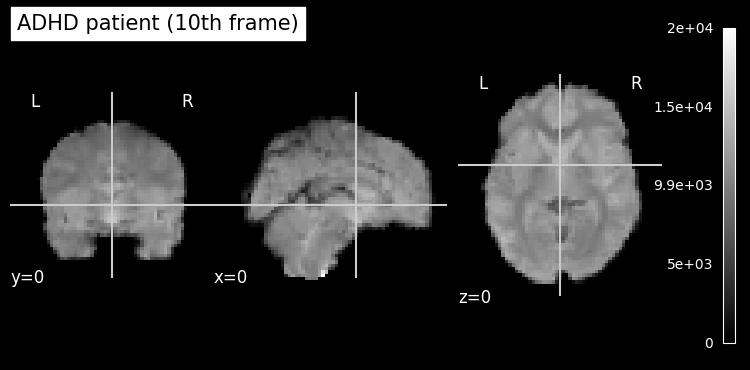

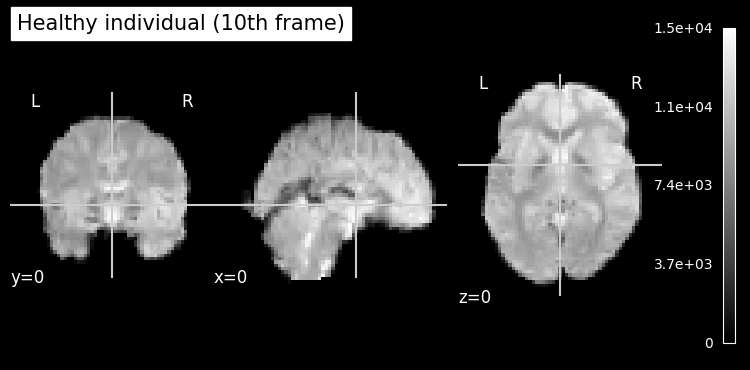

In [19]:
adhd_sub = image.load_img(adhd_dataset['func'][0])
healthy_sub = image.load_img(adhd_dataset['func'][3])
print(adhd_sub.shape)
print(healthy_sub.shape)

plotting.plot_epi(adhd_sub.slicer[:, :, :, 10], cut_coords=(0, 0, 0), title="ADHD patient (10th frame)")
plotting.plot_epi(healthy_sub.slicer[:, :, :, 10], cut_coords=(0, 0, 0), title="Healthy individual (10th frame)")

/tmp/ipython-input-1578384730.py:1: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  plotting.plot_epi(image.mean_img(adhd_sub), cut_coords=(0, 0, 0), title="ADHD patient (Average over time dimension)")
/tmp/ipython-input-1578384730.py:2: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  plotting.plot_epi(image.mean_img(healthy_sub), cut_coords=(0, 0, 0), title="Healthy individual (Average over time dimension)")


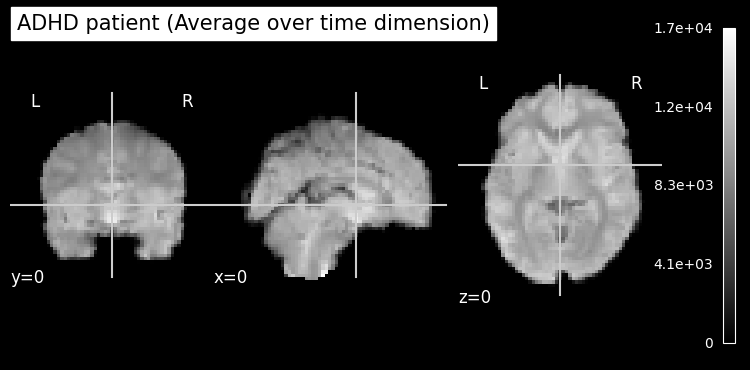

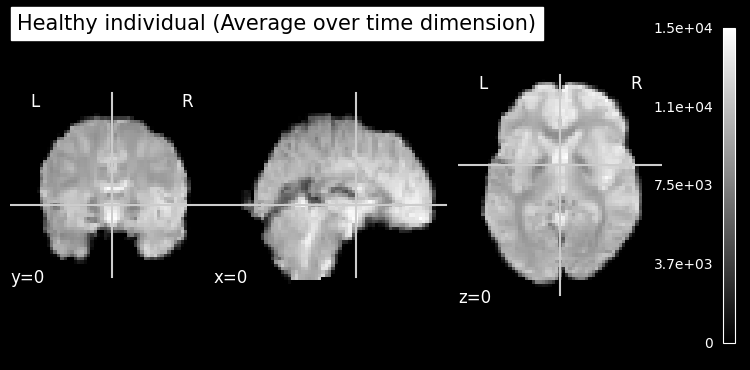

In [22]:
plotting.plot_epi(image.mean_img(adhd_sub), cut_coords=(0, 0, 0), title="ADHD patient (Average over time dimension)")
plotting.plot_epi(image.mean_img(healthy_sub), cut_coords=(0, 0, 0), title="Healthy individual (Average over time dimension)")

Putem observa zone de culori diferite. Culorile mai deschise (spre rosu) au un raspuns mai puternic adica o cantitate mai mare de sange oxigenat ceea ce reprezinta o activitate neuronala mai intensa fata de zonele mai inchise (spre albastru).

TODO 1: Alegeti un subiect random, iar pentru acesta alegeti un volum 3D (frame) random din seria temporala si afisati-l.

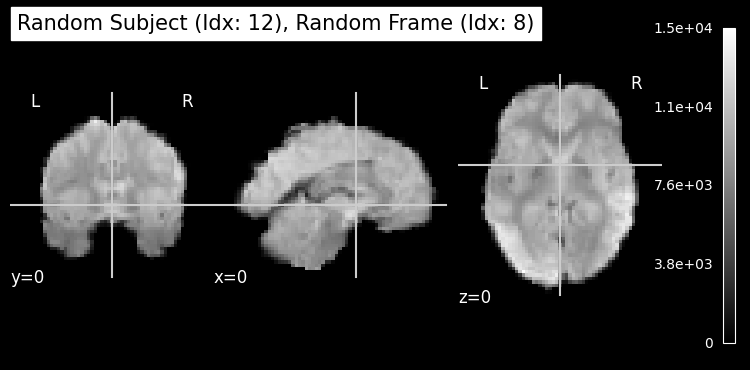

<Figure size 640x480 with 0 Axes>

In [23]:
# TODO 1: Alegeti un subiect random, iar pentru acesta alegeri un volum 3D (frame) random din seria temporala si afisati-l

func_images = adhd_dataset['func']

random_subject_idx = random.randint(0, len(func_images) - 1)

random_subject_img = image.load_img(func_images[random_subject_idx])

num_frames = random_subject_img.shape[-1]

random_frame_idx = random.randint(0, num_frames - 1)

plotting.plot_epi(random_subject_img.slicer[:, :, :, random_frame_idx],
                  cut_coords=(0, 0, 0),
                  title=f"Random Subject (Idx: {random_subject_idx}), Random Frame (Idx: {random_frame_idx})")

plt.show()
plt.clf()

## Pre-procesare

Desi imaginile functionale sunt destul de expresive din punct de vedere vizual, ele pot fi reduse intr-o forma mai compacta pentru a fi utilizate in antrenarea modelelor supervizate.

Pentru aceasta, putem aplica "atlase functionale ale creierului" (FBNs). Un atlas functional este, in fapt, un set de masti 3D, cate o masca pentru o regiune functionala de interes, ce poate fi aplicata pe fiecare volum 3D din seria temporala pentru a obtine un singur numar ce reprezinta gradul de activare a respectivei zone la acel moment de timp. Aceste zone functionale de interes sunt desprinse din fiziologia creierului, o zona ocupandu-se cu o anumita sarcina (ex: centrii vizuali, motorii, ai controlului etc.)

Astfel, dupa aplicarea unui atlas functional, imaginea 4D (x, y, z, t) este redusa la un set de serii temporale ce iau forma unei matrice 2D (t, k) unde t reprezinta coordonata temporala, iar k reprezinta numarul de astfel de zone predefinite.

De asemenea, in acest pas putem aplica si pasul aditional de denoising folosind confound-urile despre care am vorbit anterior.

In [24]:
# Incarcare confounds
confounds = pd.read_csv(adhd_dataset['confounds'][0], sep='\t', usecols=CONFOUND_COLS)
confounds = confounds.values

/tmp/ipython-input-3145299071.py:3: DeprecationWarning: From release >=0.13.0, instead of returning several atlas image accessible via different keys, this fetcher will return the atlas as a dictionary with a single atlas image, accessible through a 'maps' key. To suppress this warning, Please use the parameters 'n_networks' and 'thickness' to specify the exact atlas image you want.
  atlas = image.load_img(nilearn.datasets.fetch_atlas_yeo_2011()['thick_17'])


[fetch_atlas_yeo_2011] Dataset found in /root/nilearn_data/yeo_2011

[fetch_atlas_yeo_2011] Downloading data from 
ftp://surfer.nmr.mgh.harvard.edu/pub/data/Yeo_JNeurophysiol11_MNI152.zip ...

[fetch_atlas_yeo_2011] Resuming failed, try to download the whole file.

[fetch_atlas_yeo_2011] Downloading data from 
ftp://surfer.nmr.mgh.harvard.edu/pub/data/Yeo_JNeurophysiol11_MNI152.zip ...

[fetch_atlas_yeo_2011] Downloaded 163840 of ? bytes.

[fetch_atlas_yeo_2011] Downloaded 434176 of ? bytes.

[fetch_atlas_yeo_2011] Downloaded 745472 of ? bytes.

[fetch_atlas_yeo_2011] Downloaded 1015808 of ? bytes.

[fetch_atlas_yeo_2011] Downloaded 1302528 of ? bytes.

[fetch_atlas_yeo_2011] Downloaded 1564672 of ? bytes.

[fetch_atlas_yeo_2011] Downloaded 1835008 of ? bytes.

[fetch_atlas_yeo_2011] Downloaded 2097152 of ? bytes.

[fetch_atlas_yeo_2011] Downloaded 2359296 of ? bytes.

[fetch_atlas_yeo_2011] Downloaded 2555904 of ? bytes.

[fetch_atlas_yeo_2011]  ...done. (15 seconds, 0 min)

[fetch_atlas_yeo_2011] Extracting data from 
/root/nilearn_data/yeo_2011/622858b56913b19ae0865d9fa8ad47cc/Yeo_JNeurophysiol11_MNI152.zip...

[fetch_atlas_yeo_2011] .. done.

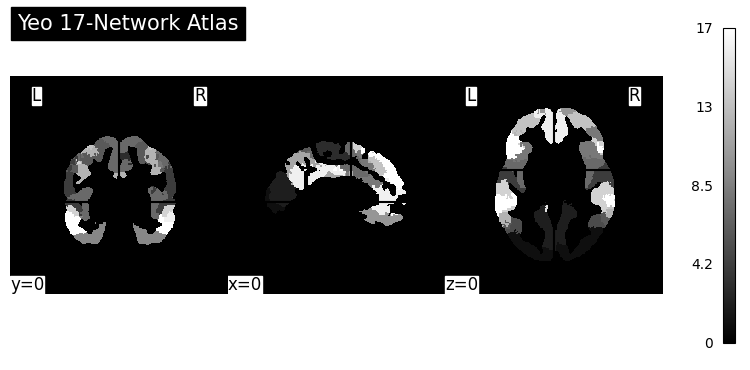

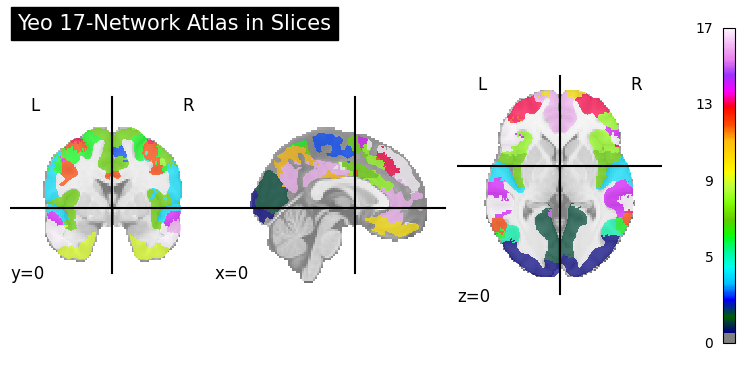

In [26]:
# Incarcare si plot atlas functional Yeo-17

atlas = image.load_img(nilearn.datasets.fetch_atlas_yeo_2011()['thick_17'])
plotting.plot_img(atlas, cut_coords=(0, 0, 0), title="Yeo 17-Network Atlas", colorbar=True)
plotting.plot_roi(atlas, cut_coords=(0, 0, 0), title="Yeo 17-Network Atlas in Slices")

In [27]:
# Aplicarea pasului de curatare si a atlasului functional

masker = NiftiLabelsMasker(labels_img=atlas, standardize=True, detrend=True)
cleaned_img = masker.fit_transform(adhd_sub, confounds)
print(adhd_sub.shape)
print(cleaned_img.shape)  # (X, Y, Z, T) -> (T, K)

(61, 73, 61, 176)
(176, 17)


TODO 2: Trasati pe acelasi grafic folosind matplotlib primele 5 semnale din cele 17 obtinute

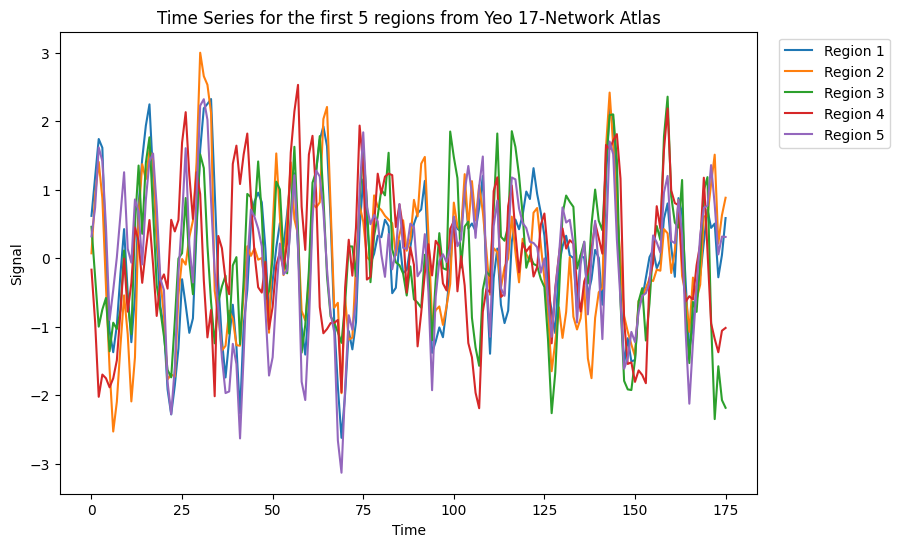

<Figure size 640x480 with 0 Axes>

In [28]:
plt.figure(figsize=(9, 6))

for i in range(5):
    plt.plot(cleaned_img[:, i], label=f'Region {i+1}')

plt.xlabel('Time')
plt.ylabel('Signal')
plt.title('Time Series for the first 5 regions from Yeo 17-Network Atlas')
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1))

plt.show()
plt.clf()

## Antrenare

Dorim sa antrenam un simplu 1D CNN pentru clasificare (ADHD sau sanatos).


In [42]:
# Preprocesarea intregului set de date

subject_images = []
subject_labels = []
# Load the atlas here, ensuring it's done once or handled correctly within the loop
# Note: The 'fetch_atlas_yeo_2011' function is already updated in cell dYIK5lix_A1V to avoid deprecation warnings
yeo_atlas_data = nilearn.datasets.fetch_atlas_yeo_2011(n_networks=7, verbose=1) # Changed to Yeo-7
atlas = image.load_img(yeo_atlas_data['maps'])

# Convert phenotypic DataFrame to a list of dictionaries for easier iteration
phenotypic_data_list = adhd_dataset['phenotypic'].to_dict(orient='records')

for confound_filename, img_filename, info in tqdm.tqdm(zip(adhd_dataset['confounds'], adhd_dataset['func'], phenotypic_data_list)):
    confounds = pd.read_csv(confound_filename, sep='	', usecols=CONFOUND_COLS)
    confounds = confounds.values

    img = image.load_img(img_filename)
    masker = NiftiLabelsMasker(labels_img=deepcopy(atlas), standardize=True, detrend=True)
    cleaned_img = masker.fit_transform(img, confounds)

    subject_images.append(cleaned_img)
    subject_labels.append(info['adhd'])

[fetch_atlas_yeo_2011] Dataset found in /root/nilearn_data/yeo_2011

30it [04:09,  8.32s/it]


In [43]:
print(len(subject_images))
print(subject_images[0].shape)
print(subject_labels)

30
(176, 7)
[1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0]


In [44]:
# Set random seeds
torch.manual_seed(40)
np.random.seed(40)
random.seed(40)

# For CUDA (GPU)
torch.cuda.manual_seed_all(40)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [45]:
X_train, X_test, y_train, y_test = train_test_split(subject_images, subject_labels, test_size=10/40, stratify=subject_labels, random_state=42)


class TimeSeriesDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return np.transpose(self.data[idx]), self.labels[idx]

train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

# Create DataLoaders
batch_size = 1
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [46]:
class CNN1D(nn.Module):
    def __init__(self, num_features=17, num_classes=2):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels=num_features, out_channels=32, kernel_size=3)
        self.bn1 = nn.BatchNorm1d(32)
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3)
        self.bn2 = nn.BatchNorm1d(64)
        self.global_pool = nn.AdaptiveAvgPool1d(1)  # Output size (batch_size, channels, 1)
        self.fc = nn.Linear(64, num_classes)  # 64 is the number of channels after conv layers

    def forward(self, x):
        x = torch.relu(self.bn1(self.conv1(x)))
        x = torch.relu(self.bn2(self.conv2(x)))
        x = self.global_pool(x)  # (batch_size, channels, 1)
        x = x.squeeze(-1)  # Remove the last dimension: (batch_size, channels)
        x = self.fc(x)  # Fully connected layer for classification
        return x

100%|██████████| 250/250 [00:11<00:00, 21.20it/s]


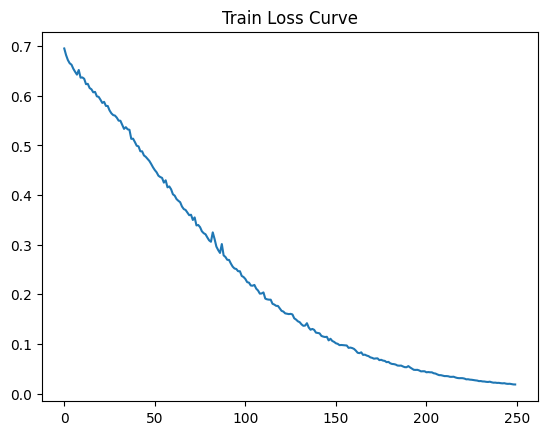

<Figure size 640x480 with 0 Axes>

In [47]:
model = CNN1D(num_features=7, num_classes=2)  # Hint 2: num_features changed to 7 for Yeo-7 atlas.
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
losses = []

# Training loop
num_epochs = 250
for epoch in tqdm.tqdm(range(num_epochs)):
    model.train()
    train_loss = 0.0
    for X, y in train_loader:
        outputs = model(X)
        loss = criterion(outputs, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    losses.append(train_loss / len(train_loader))

plt.plot(losses)
plt.title("Train Loss Curve")
plt.show()
plt.clf()

In [48]:
# Evaluate on the test set
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for batch_data, batch_labels in test_loader:
        outputs = model(batch_data)
        _, predicted = torch.max(outputs, 1)
        total += batch_labels.size(0)
        correct += (predicted == batch_labels).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")

Test Accuracy: 37.50%


TODO 3: Incercati aceeasi antrenare fara batchnorm. Ce observati legat de graficul loss-ului de antrenare?
Lossul scade mai rapid si are si variatii (nu scade la fiecare epoca)

TODO 4: Adaugati batchnorm-urile acolo unde se aflau anterior. Incercati o alta varianta a atlasului functional yeo (yeo-7, yeo-17 thin etc.) (https://nilearn.github.io/stable/modules/generated/nilearn.datasets.fetch_atlas_yeo_2011.html)

Hint 1: modificat in celula ce preproceseaza intreg setul de date (prima celulta din categoria "Antrenare").

Hint 2: atunci cand alegeti o varianta precum yeo-7 trebuie tinut cont de faptul ca numarul feature-urilor nu va mai fi 17 ci 7 (celula ce contine codul de antrenare).